## HarperNet: First Neural Network


In [190]:
# collection of import statements
from load_images import PIL_image_load, image_load, category_number_mapping
from torchvision import transforms
from torch.optim import lr_scheduler

## 1. Load our data 
* We need to load our Train, Test and Validation datasets. These have been 'hand crafted' and divided up. 

In [1]:
# these are the folders we want to use - they are the same for the test, train and validation sets 
folder_names = ["Feed","Happy", "Sleep", "Upset"]

# define our train directory 
train_dir = '/Users/drh/Documents/HarperNet/HarperImages/Train'

# define our validation directory 
val_dir = '/Users/drh/Documents/HarperNet/HarperImages/Validation'

# define our train directory 
test_dir = '/Users/drh/Documents/HarperNet/HarperImages/Test'

In [2]:
from load_images import PIL_image_load, image_load

# load our train data
train_data = image_load(train_dir,folder_names)

# check it has loaded 
len(train_data)

279

In [3]:
# load our validation data
val_data = image_load(val_dir,folder_names)

# check it has loaded 
len(val_data)

92

In [4]:
# load our test data
test_data = image_load(test_dir,folder_names)

# check it has loaded 
len(test_data)

92

In [5]:
# get a mapping 
from load_images import category_number_mapping

class_mapping = category_number_mapping(folder_names)
class_mapping

[('Feed', 0), ('Happy', 1), ('Sleep', 2), ('Upset', 3)]

**`TODO:`**
* Look up `os.join` code and glob to see if it can be improved (Geity blog; CV2, matplotlib - see my original notebook etc)
* Think harder about splitting into train, test and val. 
    * This could be done in folders, with each of TTV having the five categories 
* Can the `image_load` code be incorporated into the `Dataset` class?
* Create a chart showing the class imbalance
* Create a function to count the number of different categories in each dataset

## 2. Instantiate Dataset Class with Transforms
* We need to set up different `transforms` for the different datasets
    * train transforms are more complex as we want to provide the model with lots of variations of the images
    * all will start with `ToPILImage()` and end with `ToTensor()`
* When we transform the images, what happens to them? see here: https://discuss.pytorch.org/t/data-augmentation-in-pytorch/7925. 
    * Basically, augmentation means that each at training epoch the images are modified as per the augmentation - in a way we are adding noise, noise is good to prevent overfitting and improve the generalisation of the model 

In [10]:
# lets define our transforms first 
from torchvision import transforms

# keep original for now, for reference to resize etc.
# train_transform = transforms.Compose([transforms.ToPILImage(),
#                                transforms.Resize((256,256)),
#                                transforms.RandomCrop(224),
#                                transforms.ToTensor()])

# validation transforms 
# val_test_transform = transforms.Compose([transforms.ToPILImage(),
#                                transforms.Resize((256,256)),
#                                transforms.RandomCrop(224),
#                                transforms.ToTensor()])

In [22]:
# train transforms 
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# validation transforms 
val_test_transform = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [23]:
from data_loader import HarperNetDataset

# instantiate the train dataset class
train_dataset = HarperNetDataset(train_data, transform=train_transform)

# instantiate the validation dataset class
val_dataset = HarperNetDataset(val_data, transform=val_test_transform)

# instantiate the validation dataset class
test_dataset = HarperNetDataset(test_data, transform=val_test_transform)

In [25]:
# check the transform
for i in range(200,210):
    
    sample = train_dataset[i][0]
    label = train_dataset[i][1]
    
    print(i, sample.size(), label)

200 torch.Size([3, 224, 224]) 2
201 torch.Size([3, 224, 224]) 2
202 torch.Size([3, 224, 224]) 2
203 torch.Size([3, 224, 224]) 2
204 torch.Size([3, 224, 224]) 2
205 torch.Size([3, 224, 224]) 2
206 torch.Size([3, 224, 224]) 2
207 torch.Size([3, 224, 224]) 2
208 torch.Size([3, 224, 224]) 2
209 torch.Size([3, 224, 224]) 2


**`TODO:`**
* Refine the transforms - look at the two/three tutorials to do this. Apply different transforms to test and val dataset
* look at Story 2 and first notebook to develop some `show_images` functions before and after transformations

## 3. Create Dataloader iterators

In [26]:
# instantiate dataloader
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [28]:
# see the data loading - exciting!!!
next(iter(train_loader))[1]

tensor([ 0,  2,  3,  1,  1,  1,  2,  0,  2,  0,  0,  0,  1,  2,
         2,  2])

**`TODO:`**
* learn about `iterables` and `generators` within the context of the dataloader functionality 

## 3. Developing a model, defining loss and optimizers (and Scheduler)

In [64]:
## Create a class that contains our model architecture 
import torch
from torch import nn
from torchvision import models
import torch.nn.functional as F

class ResNetCNN(nn.Module):
    
    # class_size relates to the final layer 
    def __init__(self, class_size):
        
        # this is necessary - but need to explain this more
        # when we initialise, then we combine the variable name with EncoderCNN module
        super(ResNetCNN, self).__init__()
        
        # here we instantiate the restnet50 module
        # presumably pretrained gives us our weights?
        resnet = models.resnet50(pretrained=True)
        
        # interesting that this needs to be a loop rather than resnet.parameters().required_grad_(False)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # does order matter? here is what we have done:
        # 1. instantiated a model as resnet, with the pretrained weights
        # 2. determined that this model does not need training 
        # 3. created a list of the model layers (or params, or children!) except the last FC layer
        # 4. stored this list as the layers in the sequential element of the model 
        # 5. added a new layer, nn.Linear, which takes in the size of the final fc layer we want in resnet
        # and returns the class_size number as output
        modules = list(resnet.children())[:-1]
        
        # note the difference between resent and self.resnet
        self.resnet = nn.Sequential(*modules)
        self.category = nn.Linear(resnet.fc.in_features, class_size)

    def forward(self, images):#, class_size):
        
        # our features is a variable - presumably the output of the original image * weights etc
        # - of whatever goes through the resnet layers
        features = self.resnet(images)
        
        # we then need to reshape the output for the linear layers
        features = features.view(features.size(0), -1)
        
        ## we need to perform something here like a softmax? 
        # if class_size == 2:
            # features = self.category(features)
        
        # else:
            # F.softmax(self.category(features), dim=0)
            
            # features = self.category(F.softmax(features, dim=0))

        # features = F.softmax(self.category(features, class_size), dim=0)
        
        features = F.softmax(self.category(features), dim=0)

        return features

In [65]:
# from transfer_model import ResNetCNN

# define the number of categories as the number of folders we have
class_size = len(folder_names)

resnet = ResNetCNN(class_size=class_size)

resnet.modules

<bound method Module.modules of ResNetCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
   

In [67]:
# lets set a SGD optimizer, as per egs
import torch.optim as optim

optimizer_SGD = optim.SGD(resnet.category.parameters(), lr=0.001, momentum=0.9)

In [191]:
from torch.optim import lr_scheduler

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_SGD, step_size=7, gamma=0.1)

In [ ]:
# set loss function (think I deleted the original)

from torch.nn import nn

criterion = nn.CrossEntropyLoss()

### 3b. Fine Tuning Resnet
* I think I need to set requires_grad as True (or just omit this code)
* And ensure the optimizer is set to optimize all the layers 

In [197]:
## Create a class that contains our model architecture 
import torch
from torch import nn
from torchvision import models
import torch.nn.functional as F

class ResNetCNN_FT(nn.Module):
    
    # class_size relates to the final layer 
    def __init__(self, class_size):
        
        # this is necessary - but need to explain this more
        # when we initialise, then we combine the variable name with EncoderCNN module
        super(ResNetCNN_FT, self).__init__()
        
        # here we instantiate the restnet50 module
        # presumably pretrained gives us our weights?
        resnet = models.resnet50(pretrained=True)
        
        ## not required for fine tuning all the layers
        ## alt is to set to True
        # interesting that this needs to be a loop rather than resnet.parameters().required_grad_(False)
        # for param in resnet.parameters():
        #    param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        
        # note the difference between resent and self.resnet
        self.resnet = nn.Sequential(*modules)
        self.category = nn.Linear(resnet.fc.in_features, class_size)

    def forward(self, images):#, class_size):
        
        # our features is a variable - presumably the output of the original image * weights etc
        # - of whatever goes through the resnet layers
        features = self.resnet(images)
        
        # we then need to reshape the output for the linear layers
        features = features.view(features.size(0), -1)
        
        ## we need to perform something here like a softmax? 
        # if class_size == 2:
            # features = self.category(features)
        
        # else:
            # F.softmax(self.category(features), dim=0)
            
            # features = self.category(F.softmax(features, dim=0))

        # features = F.softmax(self.category(features, class_size), dim=0)
        
        features = F.softmax(self.category(features), dim=0)

        return features

In [198]:
# instantiate the class

resnet_ft = ResNetCNN_FT(class_size = len(folder_names))

resnet_ft.modules

<bound method Module.modules of ResNetCNN_FT(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(


In [199]:
# prepare optimizer
import torch.optim as optim

optimizer_ft = optim.SGD(resnet_ft.parameters(), lr=0.001, momentum=0.9)

In [200]:
from torch.optim import lr_scheduler

# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**`TODO:`**
* Try this with a different model, such as `VGG` and with `Squeezenet`
* Look at different options for final layers, including whether we need an activation function there
* look at fine tuning and feature extraction 
* work out how we get the weights and what the use of `children` and `parameters`, `param.requires_grad_(False)` and `pre_trained=True` are.
* work through what `optimizers` and `loss` functions we need, and what each of them do.
* use a `scheduler` for LR as per notebook 3

## 4. Train the model
* Think about what we are getting when we train a model..
    * the model weights for interference 
	* the overall model accuracy and loss, the validation and training versions.
	* there are captured in **widki** what output from the `model` or `train_loader`
    * actually, what does `train_loader` return? Lots of documentation to look up!
* What do we want to do when we train a model...
    * we want to use a train set to update the model weights
    * we test these model weights on a validation set
    * so we need to loop through through an epoch, made up of x batches, and then loop through a validation set
    * I assume that the val dataloader has only one batch in it, or we can load in the images for testing per batch?
    * we need to make a measure of performance 
        * loss is used to update the weights, via the optimizer. So we have a loss value, per batch and per epoch (avg: all the losses per batch added up / number of batches // last loss per epoch , e.g. loss = loss.item() )
        * to get the loss, we need to get the outputs of the model when the batch images are passed in 
            * again, interesting to know what criterion does here to get the loss 
        * we also need accuracy - some explanation here required in order to work out how we get accuracy
        * but we take the outputs and compare it to the actual. this gives us a percentage score.

In [116]:
# gpu code 

from torch import cuda

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: False


In [204]:
## add in early stopping

import copy
import time

model_dir = 'saved_models/'
dataframe_dir = 'dataframes/'

def train(n_epochs, train_loader, val_loader, model, optimizer, criterion, scheduler,
          print_batch=False, print_epoch=True, model_name='model_1.pt'):
    
    '''
    model_name(str): must end in .pt . Will be saved to defined model_dir
    '''

    # record length of time 
    since_total = time.time()
    
    history = []
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs):  
        
        # initiate a running loss total for train and validation sets 
        running_loss = 0.0
        val_running_loss = 0.0

        # initiate a running accuracy total for train and validation sets
        running_accuracy = 0.0
        val_running_accuracy = 0.0

        # inititate a best accuracy variable and a best model weights dictions
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        
        print('Epoch {}/{}:'.format(epoch + 1, n_epochs))
        print('-' * 10)
        
        for batch_i, (inputs, labels) in enumerate(train_loader):
            
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # test this is where this needs to be
            scheduler.step()
            
            # do we need to do thi? prepare the net for training
            model.train()      

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)
            
            ## ACCURACY
            # get predictions to help determine accuracy
            _, predictions = torch.max(outputs, 1)
            
            # get the correction predictions total by comparing predicted with actual
            correct_predictions = torch.sum(predictions == labels).item()
            
            # get an accuracy per batch
            acc_per_batch = correct_predictions / train_loader.batch_size
            
            # calculate a running total of accuracy
            running_accuracy += correct_predictions
            
            # and get an average by dividing this by the size of the dataset
            running_acc_avg = running_accuracy / (train_loader.batch_size * (batch_i + 1))

            ## LOSS
            # calculate the loss 
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()
            
            # store the loss value as a oython number in a variable 
            loss_per_batch = loss.item()
            
            # update the parameters
            optimizer.step()

            # keep a running total of our losses 
            running_loss += loss_per_batch
            
            # and an average per batch 
            running_loss_avg = running_loss / float (batch_i + 1)
            
            if print_batch:
                print('Batch {}: Loss: {:.4f}; Accuracy: {:.4f} '.format(batch_i + 1, loss_per_batch, acc_per_batch))
                
        if print_epoch:        
            print('Loss: {:.4f}; Accuracy: {:.4f}'.format(running_loss_avg, running_acc_avg))  
    
        for batch_ii, (val_inputs, val_labels) in enumerate(val_loader):
            
            if train_on_gpu:
                val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()
            
            # no requirement to monitor gradients - LOOK UP
            with torch.no_grad():
                # so set to eval mode - LOOK UP
                model.eval()
    
                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # forward pass to get outputs
                val_outputs = model(val_inputs)

                ## ACCURACY
                # get predictions to help determine accuracy
                _, val_predictions = torch.max(val_outputs, 1)

                # get the correction predictions total by comparing predicted with actual
                val_correct_predictions = torch.sum(val_predictions == val_labels).item()
                
                # val_correct_predictions = val_predictions.eq(val_labels.data.view_as(val_predictions)).item()

                # get an accuracy per batch
                val_acc_per_batch = val_correct_predictions / val_loader.batch_size

                # calculate a running total of accuracy
                val_running_accuracy += val_correct_predictions

                # and get an average by dividing this by the size of the dataset
                val_running_acc_avg = val_running_accuracy / (val_loader.batch_size * (batch_ii + 1))

                ## LOSS
                # calculate the loss  - we don't need to calculate the loss.backward or optimizer step
                val_loss = criterion(val_outputs, val_labels)

                # store the loss value as a oython number in a variable 
                val_loss_per_batch = val_loss.item()

                # keep a running total of our losses 
                val_running_loss += val_loss_per_batch

                # and an average per batch 
                val_running_loss_avg = val_running_loss / float (batch_ii + 1)
                
                if print_batch:
                    print('VAL: Batch {}: Loss: {:.4f}; Accuracy: {:.4f} '
                          .format(batch_ii + 1, val_loss_per_batch, val_acc_per_batch))

            if val_running_acc_avg > best_acc:
                best_acc = val_running_acc_avg
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_dir + model_name)
                # print('Model weights updated')
                    
        if print_epoch:        
            print('VAL: Loss: {:.4f}; Accuracy: {:.4f}'.format(val_running_loss_avg, val_running_acc_avg)) 
            print()
            
        history.append([running_loss_avg, val_running_loss_avg, running_acc_avg, val_running_acc_avg])

    time_total = time.time() - since_total
    print('Training complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    print('Finished Training')
    
     # load best model weights
    model.load_state_dict(best_model_wts)
    print('Best model weights saved')
    
    history = pd.DataFrame(data=history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    history.to_csv(dataframe_dir + model_name)
    
    return model, history

In [186]:
# run at 7am 28 Dec

epochs = 15
resenet_epoch_15 = train(epochs, train_loader, val_loader, resnet, optimizer_SGD, criterion,
                         print_batch=False)

Epoch 1/15:
----------
Loss: 1.3402; Accuracy: 0.6111
VAL: Loss: 1.3320; Accuracy: 0.6042

Epoch 2/15:
----------
Loss: 1.3429; Accuracy: 0.5521
VAL: Loss: 1.3335; Accuracy: 0.6042

Epoch 3/15:
----------
Loss: 1.3397; Accuracy: 0.6007
VAL: Loss: 1.3340; Accuracy: 0.6146

Epoch 4/15:
----------
Loss: 1.3342; Accuracy: 0.5972
VAL: Loss: 1.3283; Accuracy: 0.6146

Epoch 5/15:
----------
Loss: 1.3391; Accuracy: 0.5799
VAL: Loss: 1.3261; Accuracy: 0.6667

Epoch 6/15:
----------
Loss: 1.3324; Accuracy: 0.5312
VAL: Loss: 1.3256; Accuracy: 0.6042

Epoch 7/15:
----------
Loss: 1.3421; Accuracy: 0.5556
VAL: Loss: 1.3225; Accuracy: 0.6250

Epoch 8/15:
----------
Loss: 1.3309; Accuracy: 0.5312
VAL: Loss: 1.3294; Accuracy: 0.5729

Epoch 9/15:
----------
Loss: 1.3307; Accuracy: 0.5729
VAL: Loss: 1.3226; Accuracy: 0.5938

Epoch 10/15:
----------
Loss: 1.3358; Accuracy: 0.5312
VAL: Loss: 1.3280; Accuracy: 0.5729

Epoch 11/15:
----------
Loss: 1.3330; Accuracy: 0.5139
VAL: Loss: 1.3199; Accuracy: 0.635

In [205]:
# training at 11am 28 Dec

epochs = 30

resnet_epoch_30, r30_hist = train(epochs, train_loader, val_loader, resnet, optimizer_SGD, criterion,
                                  exp_lr_scheduler, model_name='resenet_epoch_30')

Epoch 1/30:
----------
Loss: 1.3261; Accuracy: 0.5035
VAL: Loss: 1.3117; Accuracy: 0.6354

Epoch 2/30:
----------
Loss: 1.3175; Accuracy: 0.6042
VAL: Loss: 1.3266; Accuracy: 0.5312

Epoch 3/30:
----------
Loss: 1.3216; Accuracy: 0.5451
VAL: Loss: 1.3135; Accuracy: 0.5938

Epoch 4/30:
----------
Loss: 1.3179; Accuracy: 0.5625
VAL: Loss: 1.3216; Accuracy: 0.5625

Epoch 5/30:
----------
Loss: 1.3262; Accuracy: 0.5174
VAL: Loss: 1.3218; Accuracy: 0.5521

Epoch 6/30:
----------
Loss: 1.3279; Accuracy: 0.5278
VAL: Loss: 1.3112; Accuracy: 0.6562

Epoch 7/30:
----------
Loss: 1.3247; Accuracy: 0.5382
VAL: Loss: 1.3218; Accuracy: 0.5938

Epoch 8/30:
----------
Loss: 1.3204; Accuracy: 0.5660
VAL: Loss: 1.3224; Accuracy: 0.5521

Epoch 9/30:
----------
Loss: 1.3270; Accuracy: 0.5417
VAL: Loss: 1.3126; Accuracy: 0.5833

Epoch 10/30:
----------
Loss: 1.3188; Accuracy: 0.5417
VAL: Loss: 1.3197; Accuracy: 0.6250

Epoch 11/30:
----------
Loss: 1.3229; Accuracy: 0.5556
VAL: Loss: 1.3140; Accuracy: 0.614

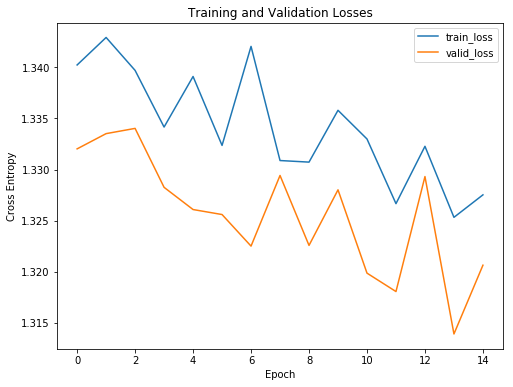

In [189]:
# function to display training and val loss 

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        resenet_epoch_15[1][c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Losses')
plt.show()

### Training the finetune model

In [206]:
# training at 12pm 28 Dec

epochs = 10

resnet_ft_test = train(epochs, train_loader, val_loader, resnet_ft, optimizer_ft, criterion,
                       lr_scheduler_ft, model_name='resenet_ft_test')

Epoch 1/10:
----------
Loss: 1.3861; Accuracy: 0.2708
VAL: Loss: 1.3850; Accuracy: 0.2292

Epoch 2/10:
----------
Loss: 1.3858; Accuracy: 0.2743
VAL: Loss: 1.3849; Accuracy: 0.2812

Epoch 3/10:
----------
Loss: 1.3851; Accuracy: 0.2951
VAL: Loss: 1.3850; Accuracy: 0.2917

Epoch 4/10:
----------
Loss: 1.3854; Accuracy: 0.2778
VAL: Loss: 1.3858; Accuracy: 0.2396

Epoch 5/10:
----------
Loss: 1.3851; Accuracy: 0.2674
VAL: Loss: 1.3851; Accuracy: 0.2396

Epoch 6/10:
----------
Loss: 1.3841; Accuracy: 0.2882
VAL: Loss: 1.3842; Accuracy: 0.2708

Epoch 7/10:
----------
Loss: 1.3850; Accuracy: 0.2847
VAL: Loss: 1.3849; Accuracy: 0.2708

Epoch 8/10:
----------
Loss: 1.3858; Accuracy: 0.2500
VAL: Loss: 1.3848; Accuracy: 0.2708

Epoch 9/10:
----------
Loss: 1.3861; Accuracy: 0.2604
VAL: Loss: 1.3848; Accuracy: 0.3229

Epoch 10/10:
----------
Loss: 1.3855; Accuracy: 0.3090
VAL: Loss: 1.3850; Accuracy: 0.2500

Training complete in 31m 43s
Finished Training
Best model weights saved


In [ ]:
# try and import function from file
import torch
from train_validate import train_model


**`TODO:`**
* add in early stopping 
* look up details on optimizer and loss functions - see Francois Chollet for rules of thumb, see what they return, try different options
* understand learning rate, scheduler options - try different combinations
* explore the reasons for `.data` or not, [here](https://discuss.pytorch.org/t/getting-data-from-tensor/2785/7) and [here](https://pytorch.org/blog/pytorch-0_4_0-migration-guide/)
    * for now, assume `.data` detaches the values for the tensor used for learning, so can be bad, but might be good in our circumstances as we are using it for reporting results!
* look at `.eval()` mode and `torch.no_grad` and `.train()`
* look up `copy` and `deepcopy`
* improve charting 
* look up `cuda` 

## Testing and Inference
* Build test function
* Build viewing functions

In [91]:
def test (test_loader, model, optimizer, criterion, print_batch=False):
    '''
    write function here
    '''
    
    print("Testing")
    print('-' * 8)
    
    # initiate a running loss total for test scores
    test_running_loss = 0.0
        
    # initiate a running accuracy total for test scores
    test_running_accuracy = 0.0
    
    for batch, (test_inputs, test_labels) in enumerate(test_loader):
        
        if train_on_gpu:
            test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()

        # no requirement to monitor gradients - LOOK UP
        with torch.no_grad():
            # so set to eval mode - LOOK UP
            model.eval()

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            test_outputs = model(test_inputs)

            ## ACCURACY
            # get predictions to help determine accuracy
            _, test_predictions = torch.max(test_outputs, 1)

            # get the correction predictions total by comparing predicted with actual
            test_correct_predictions = torch.sum(test_predictions == test_labels).item()

            # get an accuracy per batch
            test_acc_per_batch = test_correct_predictions / test_loader.batch_size

            # calculate a running total of accuracy
            test_running_accuracy += test_correct_predictions

            # and get an average by dividing this by the size of the dataset
            test_running_acc_avg = test_running_accuracy / (test_loader.batch_size * (batch + 1))

            ## LOSS
            # calculate the loss  - we don't need to calculate the loss.backward or optimizer step
            test_loss = criterion(test_outputs, test_labels)

            # store the loss value as a oython number in a variable 
            test_loss_per_batch = test_loss.item()

            # keep a running total of our losses 
            test_running_loss += test_loss_per_batch

            # and an average per batch 
            test_running_loss_avg = test_running_loss / float (batch + 1)

            if print_batch:
                print('Batch {}: Loss: {:.4f}; Accuracy: {:.4f} '
                      .format(batch + 1, test_loss_per_batch, test_acc_per_batch))

    print('Loss: {:.4f}; Accuracy: {:.4f}'.format(test_running_loss_avg, test_running_acc_avg)) 
        

In [ ]:
from test import test_model

In [120]:
test_resnet_15epochs = test(test_loader,function_test_model, optimizer_SGD, criterion, print_batch=True)

Testing
--------
Batch 1: Loss: 1.3350; Accuracy: 0.6875 
Batch 2: Loss: 1.3425; Accuracy: 0.7500 
Batch 3: Loss: 1.3510; Accuracy: 0.5000 
Batch 4: Loss: 1.3585; Accuracy: 0.5625 
Batch 5: Loss: 1.3396; Accuracy: 0.6250 
Batch 6: Loss: 1.3110; Accuracy: 0.3750 
Loss: 1.3396; Accuracy: 0.5833


### Function to display an image and its prediction

In [179]:
def prediction_actual(sample, transform, model, optimizer):
    '''
    takes in test_data output and returns an image with its correct class and model prediction
    '''
    
    # extract key information as variables
    image, category, label = sample
    
    # transform the image
    data = transform(image)
    
    with torch.no_grad():
    # so set to eval mode - LOOK UP
        model.eval()

        # zero the parameter (weight) gradients
        optimizer.zero_grad()

        data = data.unsqueeze_(0)

        # forward pass to get outputs
        output = model(data)

        ## ACCURACY
        # get predictions to help determine accuracy
        _, test_prediction = torch.max(output, 1)

        prediction = test_prediction.item()
        
        for cat, number in class_mapping:
            if prediction == number:
                convert = cat
    
    plt.imshow(image)
    plt.title('Actual: {} | Predicted: {}'.format(category, convert))
    plt.axis('off')
    

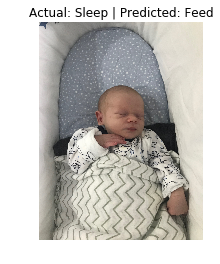

In [185]:
model_test = train_function_test_2
optimizer = optimizer_SGD
image_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

first_pred = prediction_actual(test_data[76], image_transforms, model_test, optimizer)

**TODOs**:
* Build viewing functions
* add in a way of looking at the accuracy of an individual class
* add in a function that displays an image against all the predictions